## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95


### 來自FACEBOOK RESEARCH物體偵測的最新進展：FOCAL LOSS FOR DENSE OBJECT DETECTION
https://data-sci.info/2017/08/10/%E4%BE%86%E8%87%AAfacebook-research%E7%89%A9%E9%AB%94%E5%81%B5%E6%B8%AC%E7%9A%84%E6%9C%80%E6%96%B0%E9%80%B2%E5%B1%95%EF%BC%9Afocal-loss-dense-object-detection-2/

### 機器/深度學習: 基礎介紹-損失函數(loss function)
https://medium.com/@chih.sheng.huang821/%E6%A9%9F%E5%99%A8-%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-%E5%9F%BA%E7%A4%8E%E4%BB%8B%E7%B4%B9-%E6%90%8D%E5%A4%B1%E5%87%BD%E6%95%B8-loss-function-2dcac5ebb6cb





tf.add
tf.multiply

In [0]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2., alpha=4., w=0.7): #傳參數??
    """Define the customized loss."""
    gamma = float(gamma)
    alpha = float(alpha)
    w = float(w)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        公式:
         CE(p_t) = -ln(p_t) 
         FL(p_t)=  -alpha(1-p_t)^{gamma}ln(p_t) 
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon) #tf.add 相加, tf.multiply 相乘數量要對上, 不能亂乘
        ce = tf.multiply(y_true, -tf.log(model_out)) #-tf.log? 
        
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma)) #tf.pow: 次方; 權重??
        fl = tf.multiply(alpha, tf.multiply(weight, ce)) #是調整cross entropy
        
        rew = w * ce + (1-w) * fl #改變權重, 不知道正確否??
        
        #reduced_fl = tf.reduce_max(fl, axis=1)
        reduced_fl = tf.reduce_max(rew, axis=1)
        
        return tf.reduce_mean(reduced_fl)
   
    return focal_loss_fixed
  

In [0]:
#ce權重
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [28]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))
    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer) #傳ce_w權重進loss function

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_18 (Batc (None, 128) 

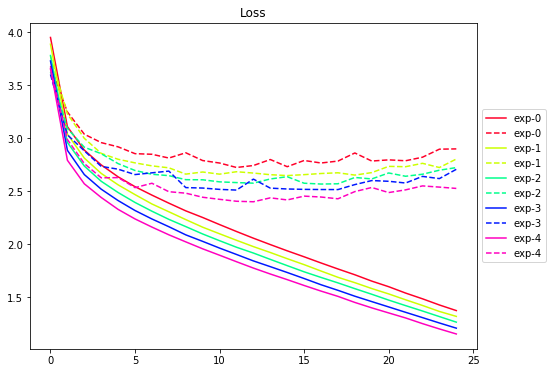

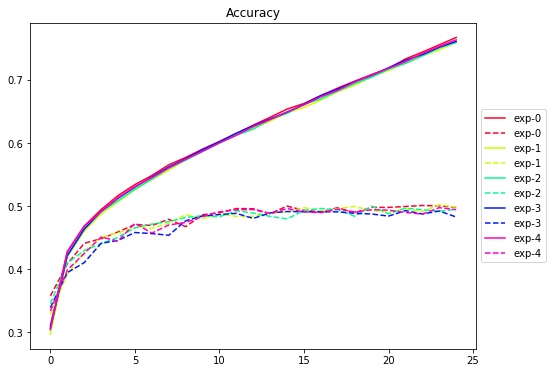

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

loss有差異, 但acc差異不大

In [13]:
def f( w=0.7):
  print( w)
  
f([0., 0.3])

[0.0, 0.3]


### Tensorflow——tf.matmul() 和tf.multiply() 的区别
https://www.jianshu.com/p/b6be1cacd94c

In [22]:
x=tf.constant([[1.0,2.0]])  
y=tf.constant([[3.3,2.0]])
z = tf.multiply(x,y)
with tf.Session() as sess: #要run才能顯示結果
    print(sess.run(2*z))

[[6.6 8. ]]
